In [1]:
import os
os.chdir("../../../")
os.getcwd()

'/project/validating_attribution_techniques'

In [2]:
from commons.api.method.adv_perturb import adversarial_noise
from commons.api.utils import set_to_our_gpus, enable_web_access
set_to_our_gpus("3")
enable_web_access()


from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images

# from shardul.ScoreCAM.cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from torchvision.models import resnet50, resnet18, vgg16, inception_v3


from shardul.api.viz import visualize_saliency_overlay


from commons.api.method.attribution import attribution


from commons.api.metric.compare_metrics import normalize, match_hist, normalize_map
from commons.api.metric.compare_metrics import SIM, CC, NSS, AUC_Judd, wasserstein_distance
from commons.api.metric.compare_metrics import calculate_metrics

In [3]:
os.chdir("/project/validating_attribution_techniques/torchCAM")
from torchcam.methods.gradient import SmoothGradCAMpp, GradCAMpp, GradCAM, LayerCAM
from torchcam.methods.activation import ScoreCAM
from torchcam.utils import overlay_mask

In [4]:
!nvidia-smi

Wed Nov  1 23:52:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:B1:00.0 Off |                  N/A |
| 28%   52C    P2              77W / 250W |    807MiB / 11264MiB |     37%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.figure import Figure
from io import BytesIO
from matplotlib.transforms import IdentityTransform

from PIL import Image
from numpy import random
import json
# import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from pyemd import emd
from cv2 import EMD
from captum.attr import LayerAttribution, LayerGradCam
import cv2
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image 
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

In [6]:
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.transforms import IdentityTransform
def text_to_rgba(s, *, dpi, **kwargs):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none", figsize=(10, 10))
    fig.text(0, 0, s, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba = plt.imread(buf)
    return rgba

In [7]:

images = np.load('/project/validating_attribution_techniques/abid/data/ground_saliency_images/images_2_fixed.npy', allow_pickle=True)
masks = np.load('/project/validating_attribution_techniques/abid/data/ground_saliency_images/obj_masks_2_fixed.npy', allow_pickle=True)

In [8]:
classes = get_imagenet_classes()

In [9]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model_resnet50 = resnet50(pretrained=True).to(device).eval()
# model_resnet18 = resnet18(pretrained=True).to(device).eval()
# model_vgg = vgg16(pretrained=True).to(device).eval()
# model_inception3 = inception_v3(pretrained=True).to(device).eval()

/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
target_layer = model_resnet50.layer4[-1]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:

img_idx = 1

In [12]:
images[img_idx].shape

(224, 224, 3)

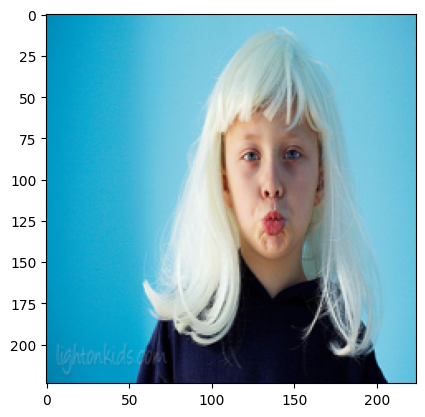

In [13]:
original_image = Image.fromarray(images[img_idx]) #Image.open('/project/validating_attribution_techniques/commons/examples/input.png') #

imshow(original_image)
input_tensor = transform(original_image).to(device)

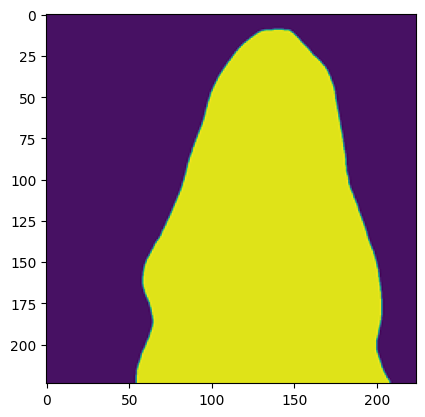

In [13]:
mask = masks[img_idx]
imshow(mask)

In [14]:
grad_cam, grad_idx, grad_probs = attribution(model_resnet50, input_tensor, "GradCAM", target_layer)
score_cam, score_idx, score_probs = attribution(model_resnet50, input_tensor, "ScoreCAM", target_layer)   
smoothgradpp_cam, smoothgradpp_idx, smoothgradpp_probs = attribution(model_resnet50, input_tensor, "SmoothGradCAMpp", target_layer)
layer_cam, layer_idx, layer_probs = attribution(model_resnet50, input_tensor, "LayerCAM", target_layer)

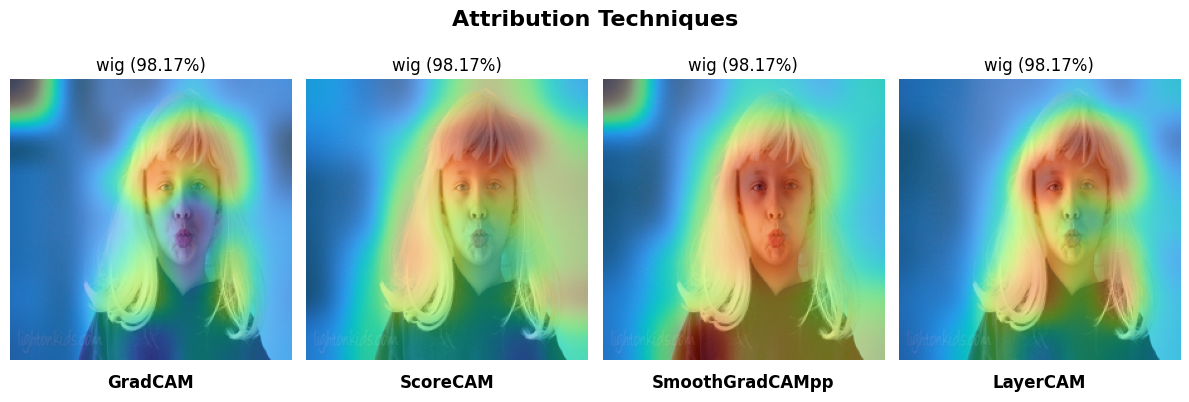

In [15]:
# fig, axes = plt.subplots(ncols=2, nrows=1)
fig, axes = plt.subplots(ncols=4, nrows=1)

fig.set_figwidth(12)
fig.set_layout_engine('tight')
fig.suptitle("Attribution Techniques", fontsize=16, fontweight="bold",y=0.9)
# fig.set_figheight(40)
# Turn off the axis for each subplot
for ax in axes:
    ax.axis('off')
# Titles for each subplot
titles = [ "GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]

visualize_saliency_overlay(axes[0], original_image, grad_cam, grad_probs, grad_idx, classes);
visualize_saliency_overlay(axes[1], original_image, score_cam, score_probs, score_idx, classes);
visualize_saliency_overlay(axes[2], original_image, smoothgradpp_cam, smoothgradpp_probs, smoothgradpp_idx, classes);
visualize_saliency_overlay(axes[3], original_image, layer_cam, layer_probs, layer_idx, classes);
for i, ax in enumerate(axes):
    ax.text(0.5, -0.1, titles[i], horizontalalignment='center', fontsize=12, fontweight='bold', transform=ax.transAxes)
# fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/Results/Ground_truth_{img_idx}.png")

In [16]:
images[img_idx].shape

(224, 224, 3)

In [17]:
# In pytorch, the shape of images are different; the first dimension must be the image channel
in_ten = torch.tensor(images[img_idx]).permute((2, 0, 1)).unsqueeze(0) / 255.0
# in_ten = torch.tensor(input_tensor).unsqueeze(0) / 255.0

# In case, we are using cuda for the model
in_ten = in_ten.to("cuda")
# resnet_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to("cuda")
# resnet_model.eval();

in_ten.shape

torch.Size([1, 3, 224, 224])

In [18]:
input_tensor.shape

torch.Size([3, 224, 224])

In [19]:
class_idx = torch.softmax(model_resnet50(in_ten), 1)[0].argmax().cpu()
int(class_idx)

669

In [20]:
# probs = torch.softmax(model_resnet50(in_ten), dim=1)
# class_idx = probs.argmax()
    
    # Get the class with the highest probability for each input
# pred_class = torch.argmax(probs, dim=1)
# probs = probs.detach().cpu().numpy()
    
#     # To extract the class ID and probability for the first input (if it's a batch):
# class_id = pred_class[0].item()

In [21]:
grad_idx

tensor(903, device='cuda:0')

## Adversial Noise

In [22]:
in_ten.device?

Type:        device
String form: cuda:0
File:        /scratch/shkulkar/python/lib/python3.8/site-packages/torch/__init__.py
Docstring:   <no docstring>

In [23]:
torch.from_numpy(cam).device?

Type:        device
String form: cuda
File:        /scratch/shkulkar/python/lib/python3.8/site-packages/torch/__init__.py
Docstring:   <no docstring>

In [24]:
# Epsilon defines the intensity of the noise. Higher values changes the image more
cam = np.array(Image.fromarray(grad_cam).resize(mask.shape))
out_ten = adversarial_noise(in_ten, model_resnet50, int(class_idx), lower_bound=0, upper_bound=1, epsilon=0.07, mask = torch.from_numpy(cam).to(device))
out_ten.squeeze().shape

/scratch/shkulkar/python/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 224, 224])

In [25]:
pertubed_grad_cam, pertubed_grad_idx, pertubed_grad_probs = attribution(model_resnet50, out_ten.squeeze(), "GradCAM", target_layer)

In [26]:
# visualize_saliency_overlay(plt.gca(), out_ten[0].permute((1, 2, 0)).cpu().numpy(), pertubed_grad_cam, pertubed_grad_probs,  class_idx, classes);


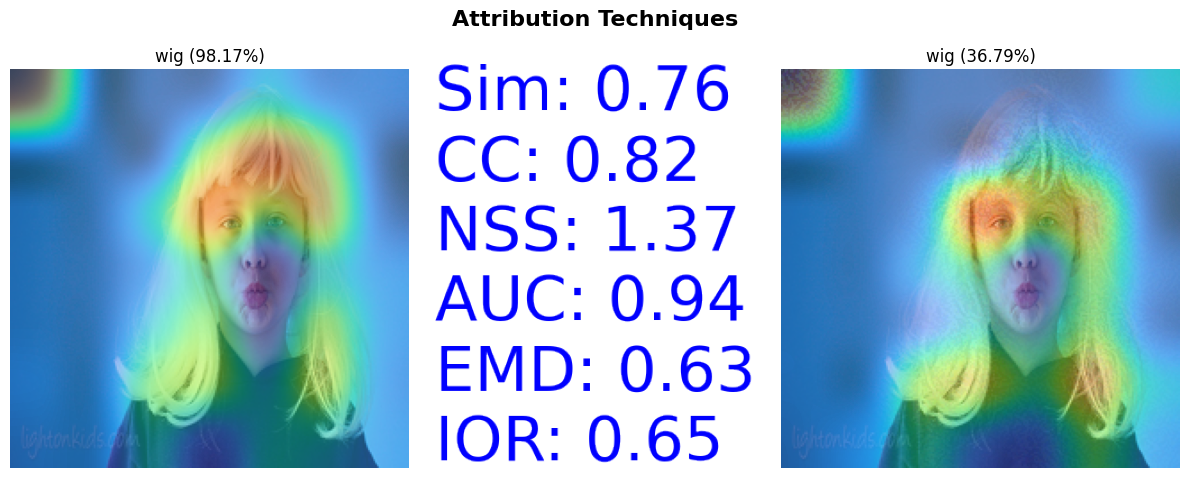

In [27]:
fig, axes = plt.subplots(ncols=3, nrows=1)

fig.set_figwidth(12)
fig.set_layout_engine('tight')
fig.suptitle("Attribution Techniques", fontsize=16, fontweight="bold",y=1.0)
# fig.set_figheight(40)
# Turn off the axis for each subplot
for ax in axes:
    ax.axis('off')
# Titles for each subplot
titles = [ "Original", "Perturbed"]

visualize_saliency_overlay(axes[0], original_image, grad_cam, grad_probs, grad_idx, classes);
visualize_saliency_overlay(axes[2], out_ten[0].permute((1, 2, 0)).cpu().numpy(), pertubed_grad_cam, pertubed_grad_probs,  int(grad_idx), classes);

#Pass two saliencies of shape
sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad = calculate_metrics(grad_cam, pertubed_grad_cam, masks[img_idx])
# perturbed_sim_score, perturbed_cc_score, perturbed_nss_score, perturbed_auc, perturbed_emd  = calculate_metrics(scorecam_mask, occlu_scorecam_mask)
    
text_grad = f"Sim: {sim_grad:.2f}\nCC: {cc_grad:.2f}\nNSS: {nss_grad:.2f}\nAUC: {auc_grad:.2f}\nEMD: {emd_grad:.2f}\nIOR: {ior_grad:.2f}"
axes[1].imshow(text_to_rgba(text_grad, color="blue", fontsize=20, dpi=200))

## Anti-Adversial Noise

In [28]:
out_ten_anti = adversarial_noise(in_ten, model_resnet50, int(class_idx), lower_bound=0, upper_bound=1, epsilon=0.06, anti_adv=True, mask = torch.from_numpy(cam).to(device))


In [29]:
anti_pertubed_grad_cam, anti_pertubed_grad_idx, anti_pertubed_grad_probs = attribution(model_resnet50, out_ten_anti.squeeze(), "GradCAM", target_layer)


In [30]:
# visualize_saliency_overlay(plt.gca(), out_ten_anti[0].permute((1, 2, 0)).cpu().numpy(), anti_pertubed_grad_cam, anti_pertubed_grad_probs,  class_idx, classes);


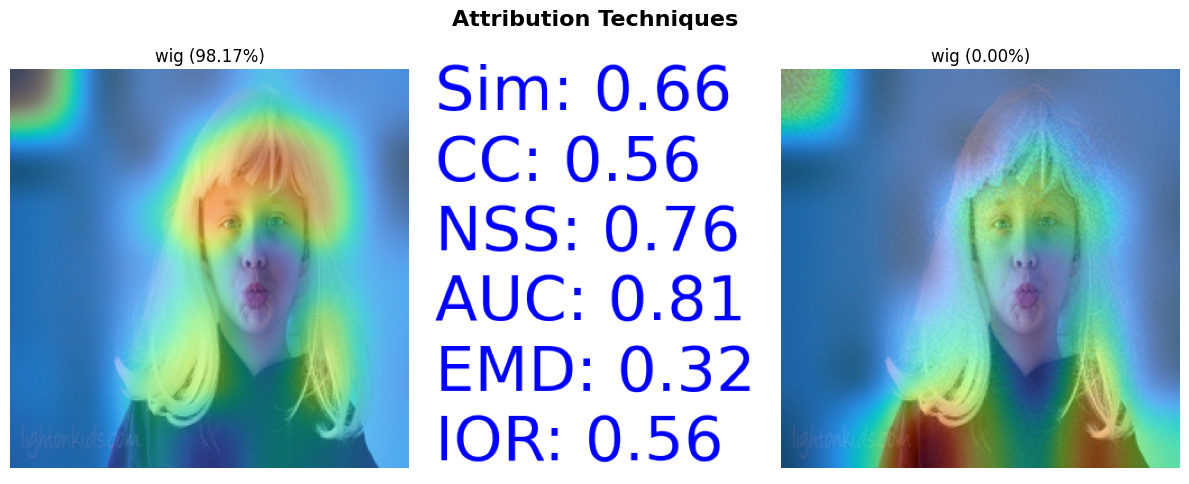

In [31]:
fig, axes = plt.subplots(ncols=3, nrows=1)

fig.set_figwidth(12)
fig.set_layout_engine('tight')
fig.suptitle("Attribution Techniques", fontsize=16, fontweight="bold",y=1.0)
# fig.set_figheight(40)
# Turn off the axis for each subplot
for ax in axes:
    ax.axis('off')
# Titles for each subplot
titles = [ "Original", "Perturbed"]

visualize_saliency_overlay(axes[0], original_image, grad_cam, grad_probs, grad_idx, classes);
visualize_saliency_overlay(axes[2], out_ten_anti[0].permute((1, 2, 0)).cpu().numpy(), anti_pertubed_grad_cam, anti_pertubed_grad_probs,  grad_idx, classes);

#Pass two saliencies of shape
sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad = calculate_metrics(grad_cam, anti_pertubed_grad_cam, masks[img_idx])
# perturbed_sim_score, perturbed_cc_score, perturbed_nss_score, perturbed_auc, perturbed_emd  = calculate_metrics(scorecam_mask, occlu_scorecam_mask)
    
text_grad = f"Sim: {sim_grad:.2f}\nCC: {cc_grad:.2f}\nNSS: {nss_grad:.2f}\nAUC: {auc_grad:.2f}\nEMD: {emd_grad:.2f}\nIOR: {ior_grad:.2f}"
axes[1].imshow(text_to_rgba(text_grad, color="blue", fontsize=20, dpi=200))

## Multiple Images using different Epsilon values

In [32]:
# def initialize_metrics_values(techniques, metrics):
#     metrics_values = {}
#     for technique in techniques:
#         metrics_values[technique] = {}
#         for metric in metrics:
#             metrics_values[technique][metric] = []
#     return metrics_values


# Define the techniques and metrics you want to collect

# Define the techniques and metrics you want to collect
techniques = ["GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
metrics = ["sim", "cc", "nss", "auc", "emd", "ior"]

# Define the noise categories
noise = ["Adversial", "Anti-Adversial"]

# Initialize the metrics_values dictionary
metrics_values = {noise_category: {technique: {metric: [] for metric in metrics} for technique in techniques} for noise_category in noise}


In [33]:
indexes = [i for i in range(0, 61)]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60


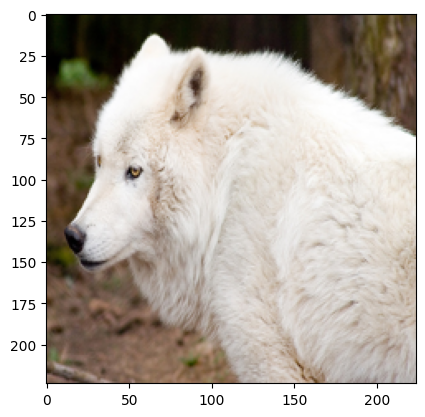

In [42]:
ep = 0.07 
anti_ep = 0.07

for img_idx in indexes:
    print(f"Iteration: {img_idx}" )
    original_image = Image.fromarray(images[img_idx])
    imshow(original_image)
    input_tensor = transform(original_image).to(device)
    mask = masks[img_idx]

    in_ten = torch.tensor(images[img_idx]).permute((2, 0, 1)).unsqueeze(0) / 255.0
    # In case, we are using cuda for the model
    in_ten = in_ten.to("cuda")
    
    #if in case you do not want to specify target layer(default is set to 'layer4')
    grad_cam, grad_idx, grad_probs = attribution(model_resnet50, input_tensor, "GradCAM", target_layer)
    score_cam, score_idx, score_probs = attribution(model_resnet50, input_tensor, "ScoreCAM", target_layer)   
    smoothgradpp_cam, smoothgradpp_idx, smoothgradpp_probs = attribution(model_resnet50, input_tensor, "SmoothGradCAMpp", target_layer)
    layer_cam, layer_idx, layer_probs = attribution(model_resnet50, input_tensor, "LayerCAM", target_layer)

    titles = [ "GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]

    gradcam = np.array([])
    scorecam = np.array([])
    smoothgradcampp = np.array([])
    layercam = np.array([])
    
    # sample_occlu_imgs = np.load(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Occlusion_Results/Single_Patch/Img_{img_idx}/occluded_image_list_patch_{patch_size}_idx_{img_idx}.npy")
    # Image.fromarray((sample_occlu_imgs[0]* 255).astype(np.uint8))
    titles = [ "GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
    # print(rows)
    fig, axes = plt.subplots(ncols=8, nrows=3)
    # Iterate through axes and turn off the axes for each subplot
    for row in axes:
        for ax in row:
            ax.axis('off')
    
    for row in range(axes.shape[0]):
        for col in [0, 2, 4, 6]:
            # Add the title at the bottom of the image
            title = titles[col // 2]
            axes[row, col].text(0.5, -0.12, title, horizontalalignment='center', fontsize=12, fontweight='bold', transform=axes[row, col].transAxes)

    for j in [0, 2, 4, 6]:
        axes[1, j].text(0.5, -0.24, noise[0], horizontalalignment="center", fontsize=12, fontweight="bold", transform=axes[1, j].transAxes)
        axes[2, j].text(0.5, -0.24, noise[1], horizontalalignment="center", fontsize=12, fontweight="bold", transform=axes[2, j].transAxes)
    
    fig.set_figheight(10)
    fig.set_figwidth(20)

    grad = torch.from_numpy(np.array(Image.fromarray(grad_cam).resize(mask.shape))).to(device)
    score = torch.from_numpy(np.array(Image.fromarray(score_cam).resize(mask.shape))).to(device)
    smooth = torch.from_numpy(np.array(Image.fromarray(smoothgradpp_cam).resize(mask.shape))).to(device)
    layer = torch.from_numpy(np.array(Image.fromarray(layer_cam).resize(mask.shape))).to(device)

    
    out_ten_grad = adversarial_noise(in_ten, model_resnet50, int(grad_idx), lower_bound=0, upper_bound=1, epsilon=ep, mask = grad)
    out_ten_score = adversarial_noise(in_ten, model_resnet50, int(score_idx), lower_bound=0, upper_bound=1, epsilon=ep, mask = score)
    out_ten_smooth = adversarial_noise(in_ten, model_resnet50, int(smoothgradpp_idx), lower_bound=0, upper_bound=1, epsilon=ep, mask = smooth)
    out_ten_layer = adversarial_noise(in_ten, model_resnet50, int(layer_idx), lower_bound=0, upper_bound=1, epsilon=ep, mask = layer)
    
    pertubed_grad_cam, pertubed_grad_idx, pertubed_grad_probs = attribution(model_resnet50,  out_ten_grad.squeeze(), "GradCAM", target_layer)
    pertubed_score_cam, pertubed_score_idx, pertubed_score_probs = attribution(model_resnet50,  out_ten_score.squeeze(), "ScoreCAM", target_layer)   
    pertubed_smoothgradpp_cam, pertubed_smoothgradpp_idx, pertubed_smoothgradpp_probs = attribution(model_resnet50,  out_ten_smooth.squeeze(), "SmoothGradCAMpp", target_layer)
    pertubed_layer_cam, pertubed_layer_idx, pertubed_layer_probs = attribution(model_resnet50,  out_ten_layer.squeeze(), "LayerCAM", target_layer)

    anti_out_ten_grad = adversarial_noise(in_ten, model_resnet50, int(grad_idx), lower_bound=0, upper_bound=1, epsilon=anti_ep, anti_adv=True, mask = grad)
    anti_out_ten_score = adversarial_noise(in_ten, model_resnet50, int(score_idx), lower_bound=0, upper_bound=1, epsilon=anti_ep, anti_adv=True, mask = score)
    anti_out_ten_smooth = adversarial_noise(in_ten, model_resnet50, int(smoothgradpp_idx), lower_bound=0, upper_bound=1, epsilon=anti_ep, anti_adv=True, mask = smooth)
    anti_out_ten_layer = adversarial_noise(in_ten, model_resnet50, int(layer_idx), lower_bound=0, upper_bound=1, epsilon=anti_ep, anti_adv=True, mask = layer)

    anti_pertubed_grad_cam, anti_pertubed_grad_idx, anti_pertubed_grad_probs = attribution(model_resnet50,  anti_out_ten_grad.squeeze(), "GradCAM", target_layer)
    anti_pertubed_score_cam, anti_pertubed_score_idx, anti_pertubed_score_probs = attribution(model_resnet50,  anti_out_ten_score.squeeze(), "ScoreCAM", target_layer)   
    anti_pertubed_smoothgradpp_cam, anti_pertubed_smoothgradpp_idx, anti_pertubed_smoothgradpp_probs = attribution(model_resnet50,  anti_out_ten_smooth.squeeze(), "SmoothGradCAMpp", target_layer)
    anti_pertubed_layer_cam, anti_pertubed_layer_idx, anti_pertubed_layer_probs = attribution(model_resnet50,  anti_out_ten_layer.squeeze(), "LayerCAM", target_layer)

    visualize_saliency_overlay(axes[0, 0], original_image, grad_cam, grad_probs, grad_idx, classes);
    visualize_saliency_overlay(axes[0, 2], original_image, score_cam, score_probs, score_idx, classes);
    visualize_saliency_overlay(axes[0, 4], original_image, smoothgradpp_cam, smoothgradpp_probs, smoothgradpp_idx, classes);
    visualize_saliency_overlay(axes[0, 6], original_image, layer_cam, layer_probs, layer_idx, classes);

    visualize_saliency_overlay(axes[1, 0], out_ten_grad[0].permute((1, 2, 0)).cpu().numpy(), pertubed_grad_cam, pertubed_grad_probs, grad_idx, classes);    
    visualize_saliency_overlay(axes[1, 2], out_ten_score[0].permute((1, 2, 0)).cpu().numpy(), pertubed_score_cam, pertubed_score_probs, score_idx, classes);
    visualize_saliency_overlay(axes[1, 4], out_ten_smooth[0].permute((1, 2, 0)).cpu().numpy(), pertubed_smoothgradpp_cam, pertubed_smoothgradpp_probs, smoothgradpp_idx, classes);    
    visualize_saliency_overlay(axes[1, 6], out_ten_layer[0].permute((1, 2, 0)).cpu().numpy(), pertubed_layer_cam, pertubed_layer_probs, layer_idx, classes);

    visualize_saliency_overlay(axes[2, 0], anti_out_ten_grad[0].permute((1, 2, 0)).cpu().numpy(), anti_pertubed_grad_cam, anti_pertubed_grad_probs, grad_idx, classes);    
    visualize_saliency_overlay(axes[2, 2], anti_out_ten_score[0].permute((1, 2, 0)).cpu().numpy(), anti_pertubed_score_cam, anti_pertubed_score_probs, score_idx, classes);
    visualize_saliency_overlay(axes[2, 4], anti_out_ten_smooth[0].permute((1, 2, 0)).cpu().numpy(), anti_pertubed_smoothgradpp_cam, anti_pertubed_smoothgradpp_probs, smoothgradpp_idx, classes);    
    visualize_saliency_overlay(axes[2, 6], anti_out_ten_layer[0].permute((1, 2, 0)).cpu().numpy(), anti_pertubed_layer_cam, anti_pertubed_layer_probs, layer_idx, classes);

    sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad = calculate_metrics(grad_cam, pertubed_grad_cam, mask) 
    text_grad = f"Sim: {sim_grad:.2f}\nCC: {cc_grad:.2f}\nNSS: {nss_grad:.2f}\nAUC: {auc_grad:.2f}\nEMD: {emd_grad:.2f}\nIOR: {ior_grad:.2f}"
    
    sim_score, cc_score, nss_score, auc_score, emd_score, ior_score = calculate_metrics(score_cam, pertubed_score_cam, mask) 
    text_score = f"Sim: {sim_score:.2f}\nCC: {cc_score:.2f}\nNSS: {nss_score:.2f}\nAUC: {auc_score:.2f}\nEMD: {emd_score:.2f}\nIOR: {ior_score:.2f}"
    
    sim_smooth, cc_smooth, nss_smooth, auc_smooth, emd_smooth, ior_smooth = calculate_metrics(smoothgradpp_cam, pertubed_smoothgradpp_cam, mask) 
    text_smooth = f"Sim: {sim_smooth:.2f}\nCC: {cc_smooth:.2f}\nNSS: {nss_smooth:.2f}\nAUC: {auc_smooth:.2f}\nEMD: {emd_smooth:.2f}\nIOR: {ior_smooth:.2f}"
    
    sim_layer, cc_layer, nss_layer, auc_layer, emd_layer, ior_layer = calculate_metrics(layer_cam, pertubed_layer_cam, mask) 
    text_layer = f"Sim: {sim_layer:.2f}\nCC: {cc_layer:.2f}\nNSS: {nss_layer:.2f}\nAUC: {auc_layer:.2f}\nEMD: {emd_layer:.2f}\nIOR: {ior_layer:.2f}"

    anti_sim_grad, anti_cc_grad, anti_nss_grad, anti_auc_grad, anti_emd_grad, anti_ior_grad = calculate_metrics(grad_cam, anti_pertubed_grad_cam, mask) 
    anti_text_grad = f"Sim: {anti_sim_grad:.2f}\nCC: {anti_cc_grad:.2f}\nNSS: {anti_nss_grad:.2f}\nAUC: {anti_auc_grad:.2f}\nEMD: {anti_emd_grad:.2f}\nIOR: {anti_ior_grad:.2f}"
    
    anti_sim_score, anti_cc_score, anti_nss_score, anti_auc_score, anti_emd_score, anti_ior_score = calculate_metrics(score_cam, anti_pertubed_score_cam, mask) 
    anti_text_score = f"Sim: {anti_sim_score:.2f}\nCC: {anti_cc_score:.2f}\nNSS: {anti_nss_score:.2f}\nAUC: {anti_auc_score:.2f}\nEMD: {anti_emd_score:.2f}\nIOR: {anti_ior_score:.2f}"
    
    anti_sim_smooth, anti_cc_smooth, anti_nss_smooth, anti_auc_smooth, anti_emd_smooth, anti_ior_smooth = calculate_metrics(smoothgradpp_cam, anti_pertubed_smoothgradpp_cam, mask) 
    anti_text_smooth = f"Sim: {anti_sim_smooth:.2f}\nCC: {anti_cc_smooth:.2f}\nNSS: {anti_nss_smooth:.2f}\nAUC: {anti_auc_smooth:.2f}\nEMD: {anti_emd_smooth:.2f}\nIOR: {anti_ior_smooth:.2f}"
    
    anti_sim_layer, anti_cc_layer, anti_nss_layer, anti_auc_layer, anti_emd_layer, anti_ior_layer = calculate_metrics(layer_cam, anti_pertubed_layer_cam, mask) 
    anti_text_layer = f"Sim: {anti_sim_layer:.2f}\nCC: {anti_cc_layer:.2f}\nNSS: {anti_nss_layer:.2f}\nAUC: {anti_auc_layer:.2f}\nEMD: {anti_emd_layer:.2f}\nIOR: {anti_ior_layer:.2f}"

    axes[1, 1].imshow(text_to_rgba(text_grad, color="blue", fontsize=10, dpi=200))
    axes[1, 3].imshow(text_to_rgba(text_score, color="blue", fontsize=10, dpi=200))
    axes[1, 5].imshow(text_to_rgba(text_smooth, color="blue", fontsize=10, dpi=200))
    axes[1, 7].imshow(text_to_rgba(text_layer, color="blue", fontsize=10, dpi=200))

    axes[2, 1].imshow(text_to_rgba(anti_text_grad, color="blue", fontsize=10, dpi=200))
    axes[2, 3].imshow(text_to_rgba(anti_text_score, color="blue", fontsize=10, dpi=200))
    axes[2, 5].imshow(text_to_rgba(anti_text_smooth, color="blue", fontsize=10, dpi=200))
    axes[2, 7].imshow(text_to_rgba(anti_text_layer, color="blue", fontsize=10, dpi=200))

    for noise_category in noise:
        for technique in techniques:
            for metric in metrics:
                calculated_value = None
    
                if noise_category == "Adversial":
                    if technique == "GradCAM":
                        calculated_value = locals()[metric.lower() + "_grad"]
                    elif technique == "ScoreCAM":
                        calculated_value = locals()[metric.lower() + "_score"]
                    elif technique == "SmoothGradCAMpp":
                        calculated_value = locals()[metric.lower() + "_smooth"]
                    elif technique == "LayerCAM":
                        calculated_value = locals()[metric.lower() + "_layer"]
                        
                elif noise_category == "Anti-Adversial":
                    if technique == "GradCAM":
                        calculated_value = locals()["anti_" + metric.lower() + "_grad"]
                    elif technique == "ScoreCAM":
                        calculated_value = locals()["anti_" + metric.lower() + "_score"]
                    elif technique == "SmoothGradCAMpp":
                        calculated_value = locals()["anti_" + metric.lower() + "_smooth"]
                    elif technique == "LayerCAM":
                        calculated_value = locals()["anti_" + metric.lower() + "_layer"]
                metrics_values[noise_category][technique][metric] = calculated_value


    del sim_layer, cc_layer, nss_layer, auc_layer, emd_layer, ior_layer, anti_sim_grad, anti_cc_grad, anti_nss_grad, anti_auc_grad, anti_emd_grad, anti_ior_grad
    del sim_smooth, cc_smooth, nss_smooth, auc_smooth, emd_smooth, ior_smooth, anti_sim_score, anti_cc_score, anti_nss_score, anti_auc_score, anti_emd_score, anti_ior_score
    del sim_score, cc_score, nss_score, auc_score, emd_score, ior_score, anti_sim_smooth, anti_cc_smooth, anti_nss_smooth, anti_auc_smooth, anti_emd_smooth, anti_ior_smooth
    del sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad, anti_sim_layer, anti_cc_layer, anti_nss_layer, anti_auc_layer, anti_emd_layer, anti_ior_layer
    
    fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation//Noise_Results/Img_{img_idx}/Noise_ad_{ep}_anti_{anti_ep}_{img_idx}.png")
    plt.close(fig)
    def convert_to_standard_float(obj):
        if isinstance(obj, np.float32):
            return float(obj)
        raise TypeError

    output_file = f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation//Noise_Results/Img_{img_idx}/metrics_ad_{ep}_anti_{anti_ep}_{img_idx}.json"
    # Check if the file already exists and delete it
    if os.path.exists(output_file):
        os.remove(output_file)
    with open(output_file, 'w') as json_file:
        json.dump(metrics_values, json_file, indent=4, default=convert_to_standard_float)




# Summary

In [11]:
import numpy as np
# Define the number of images
num_images = 100

# Define the CAM techniques
cam_techniques = ["GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]

# Define the metric types
metric_types = ["sim", "cc", "nss", "auc", "emd", "ior"]

# Create dictionaries to store metrics for each CAM technique and metric type
adversarial_metrics = {}
anti_adversarial_metrics = {}
adversarial_summary = {}
anti_adversarial_summary = {}

# Initialize arrays to store metrics for each CAM technique and metric type
for cam in cam_techniques:
    adversarial_metrics[cam] = {}
    anti_adversarial_metrics[cam] = {}
    for metric in metric_types:
        adversarial_metrics[cam][metric] = np.zeros((num_images,))
        anti_adversarial_metrics[cam][metric] = np.zeros((num_images,))

# Create arrays to store raw NSS and EMD values for each metric and CAM technique
raw_nss_values = {}
raw_emd_values = {}

for cam in cam_techniques:
    raw_nss_values[cam] = np.zeros((num_images,))
    raw_emd_values[cam] = np.zeros((num_images,))


In [12]:
indexes = [i for i in range(0, 100)]

Iteration: 0


/scratch/shkulkar/python/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

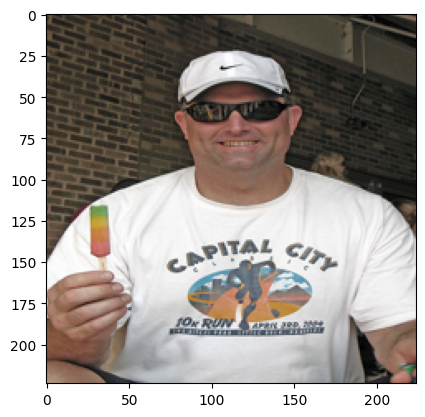

In [13]:
ep = 0.01
anti_ep = 0.01
model = model_resnet50
for img_idx in indexes:
    print(f"Iteration: {img_idx}" )
    original_image = Image.fromarray(images[img_idx])
    imshow(original_image)
    input_tensor = transform(original_image).to(device)
    mask = masks[img_idx]

    in_ten = torch.tensor(images[img_idx]).permute((2, 0, 1)).unsqueeze(0) / 255.0
    # In case, we are using cuda for the model
    in_ten = in_ten.to("cuda")
    
    #if in case you do not want to specify target layer(default is set to 'layer4')
    grad_cam, grad_idx, grad_probs = attribution(model, input_tensor, "GradCAM", target_layer)
    score_cam, score_idx, score_probs = attribution(model, input_tensor, "ScoreCAM", target_layer)   
    smoothgradpp_cam, smoothgradpp_idx, smoothgradpp_probs = attribution(model, input_tensor, "SmoothGradCAMpp", target_layer)
    layer_cam, layer_idx, layer_probs = attribution(model, input_tensor, "LayerCAM", target_layer)

    titles = [ "GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]

    grad = torch.from_numpy(np.array(Image.fromarray(grad_cam).resize(mask.shape))).to(device)
    score = torch.from_numpy(np.array(Image.fromarray(score_cam).resize(mask.shape))).to(device)
    smooth = torch.from_numpy(np.array(Image.fromarray(smoothgradpp_cam).resize(mask.shape))).to(device)
    layer = torch.from_numpy(np.array(Image.fromarray(layer_cam).resize(mask.shape))).to(device)

    
    out_ten_grad = adversarial_noise(in_ten, model, int(grad_idx), lower_bound=0, upper_bound=1, epsilon=ep, mask = grad)
    out_ten_score = adversarial_noise(in_ten, model, int(score_idx), lower_bound=0, upper_bound=1, epsilon=ep, mask = score)
    out_ten_smooth = adversarial_noise(in_ten, model, int(smoothgradpp_idx), lower_bound=0, upper_bound=1, epsilon=ep, mask = smooth)
    out_ten_layer = adversarial_noise(in_ten, model, int(layer_idx), lower_bound=0, upper_bound=1, epsilon=ep, mask = layer)
    
    pertubed_grad_cam, pertubed_grad_idx, pertubed_grad_probs = attribution(model,  out_ten_grad.squeeze(), "GradCAM", target_layer)
    pertubed_score_cam, pertubed_score_idx, pertubed_score_probs = attribution(model,  out_ten_score.squeeze(), "ScoreCAM", target_layer)   
    pertubed_smoothgradpp_cam, pertubed_smoothgradpp_idx, pertubed_smoothgradpp_probs = attribution(model,  out_ten_smooth.squeeze(), "SmoothGradCAMpp", target_layer)
    pertubed_layer_cam, pertubed_layer_idx, pertubed_layer_probs = attribution(model,  out_ten_layer.squeeze(), "LayerCAM", target_layer)

    anti_out_ten_grad = adversarial_noise(in_ten, model, int(grad_idx), lower_bound=0, upper_bound=1, epsilon=anti_ep, anti_adv=True, mask = grad)
    anti_out_ten_score = adversarial_noise(in_ten, model, int(score_idx), lower_bound=0, upper_bound=1, epsilon=anti_ep, anti_adv=True, mask = score)
    anti_out_ten_smooth = adversarial_noise(in_ten, model, int(smoothgradpp_idx), lower_bound=0, upper_bound=1, epsilon=anti_ep, anti_adv=True, mask = smooth)
    anti_out_ten_layer = adversarial_noise(in_ten, model, int(layer_idx), lower_bound=0, upper_bound=1, epsilon=anti_ep, anti_adv=True, mask = layer)

    anti_pertubed_grad_cam, anti_pertubed_grad_idx, anti_pertubed_grad_probs = attribution(model,  anti_out_ten_grad.squeeze(), "GradCAM", target_layer)
    anti_pertubed_score_cam, anti_pertubed_score_idx, anti_pertubed_score_probs = attribution(model,  anti_out_ten_score.squeeze(), "ScoreCAM", target_layer)   
    anti_pertubed_smoothgradpp_cam, anti_pertubed_smoothgradpp_idx, anti_pertubed_smoothgradpp_probs = attribution(model,  anti_out_ten_smooth.squeeze(), "SmoothGradCAMpp", target_layer)
    anti_pertubed_layer_cam, anti_pertubed_layer_idx, anti_pertubed_layer_probs = attribution(model,  anti_out_ten_layer.squeeze(), "LayerCAM", target_layer)


    sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad = calculate_metrics(grad_cam, pertubed_grad_cam, mask) 
    
    sim_score, cc_score, nss_score, auc_score, emd_score, ior_score = calculate_metrics(score_cam, pertubed_score_cam, mask) 
    
    sim_smooth, cc_smooth, nss_smooth, auc_smooth, emd_smooth, ior_smooth = calculate_metrics(smoothgradpp_cam, pertubed_smoothgradpp_cam, mask) 
    
    sim_layer, cc_layer, nss_layer, auc_layer, emd_layer, ior_layer = calculate_metrics(layer_cam, pertubed_layer_cam, mask) 

    adversarial_metrics["GradCAM"]["sim"][img_idx] = sim_grad
    adversarial_metrics["GradCAM"]["cc"][img_idx] = cc_grad
    raw_nss_values["GradCAM"][img_idx] = nss_grad
    raw_emd_values["GradCAM"][img_idx] = emd_grad
    adversarial_metrics["GradCAM"]["auc"][img_idx] = auc_grad
    adversarial_metrics["GradCAM"]["emd"][img_idx] = emd_grad
    adversarial_metrics["GradCAM"]["ior"][img_idx] = ior_grad

    adversarial_metrics["ScoreCAM"]["sim"][img_idx] = sim_score
    adversarial_metrics["ScoreCAM"]["cc"][img_idx] = cc_score
    raw_nss_values["ScoreCAM"][img_idx] = nss_score
    raw_emd_values["ScoreCAM"][img_idx] = emd_score
    adversarial_metrics["ScoreCAM"]["auc"][img_idx] = auc_score
    adversarial_metrics["ScoreCAM"]["emd"][img_idx] = emd_score
    adversarial_metrics["ScoreCAM"]["ior"][img_idx] = ior_score

    adversarial_metrics["SmoothGradCAMpp"]["sim"][img_idx] = sim_smooth
    adversarial_metrics["SmoothGradCAMpp"]["cc"][img_idx] = cc_smooth
    raw_nss_values["SmoothGradCAMpp"][img_idx] = nss_smooth
    raw_emd_values["SmoothGradCAMpp"][img_idx] = emd_smooth
    adversarial_metrics["SmoothGradCAMpp"]["auc"][img_idx] = auc_smooth
    adversarial_metrics["SmoothGradCAMpp"]["emd"][img_idx] = emd_smooth
    adversarial_metrics["SmoothGradCAMpp"]["ior"][img_idx] = ior_smooth

    adversarial_metrics["LayerCAM"]["sim"][img_idx] = sim_layer
    adversarial_metrics["LayerCAM"]["cc"][img_idx] = cc_layer
    raw_nss_values["LayerCAM"][img_idx] = nss_layer
    raw_emd_values["LayerCAM"][img_idx] = emd_layer
    adversarial_metrics["LayerCAM"]["auc"][img_idx] = auc_layer
    adversarial_metrics["LayerCAM"]["emd"][img_idx] = emd_layer
    adversarial_metrics["LayerCAM"]["ior"][img_idx] = ior_layer


    anti_sim_grad, anti_cc_grad, anti_nss_grad, anti_auc_grad, anti_emd_grad, anti_ior_grad = calculate_metrics(grad_cam, anti_pertubed_grad_cam, mask) 
    
    anti_sim_score, anti_cc_score, anti_nss_score, anti_auc_score, anti_emd_score, anti_ior_score = calculate_metrics(score_cam, anti_pertubed_score_cam, mask) 
    
    anti_sim_smooth, anti_cc_smooth, anti_nss_smooth, anti_auc_smooth, anti_emd_smooth, anti_ior_smooth = calculate_metrics(smoothgradpp_cam, anti_pertubed_smoothgradpp_cam, mask) 
    
    anti_sim_layer, anti_cc_layer, anti_nss_layer, anti_auc_layer, anti_emd_layer, anti_ior_layer = calculate_metrics(layer_cam, anti_pertubed_layer_cam, mask) 

    anti_adversarial_metrics["GradCAM"]["sim"][img_idx] = anti_sim_grad
    anti_adversarial_metrics["GradCAM"]["cc"][img_idx] = anti_cc_grad
    raw_nss_values["GradCAM"][img_idx] = anti_nss_grad
    raw_emd_values["GradCAM"][img_idx] = anti_emd_grad
    anti_adversarial_metrics["GradCAM"]["auc"][img_idx] = anti_auc_grad
    anti_adversarial_metrics["GradCAM"]["emd"][img_idx] = anti_emd_grad
    anti_adversarial_metrics["GradCAM"]["ior"][img_idx] = anti_ior_grad

    anti_adversarial_metrics["ScoreCAM"]["sim"][img_idx] = anti_sim_score
    anti_adversarial_metrics["ScoreCAM"]["cc"][img_idx] = anti_cc_score
    raw_nss_values["ScoreCAM"][img_idx] = anti_nss_score
    raw_emd_values["ScoreCAM"][img_idx] = anti_emd_score
    anti_adversarial_metrics["ScoreCAM"]["auc"][img_idx] = anti_auc_score
    anti_adversarial_metrics["ScoreCAM"]["emd"][img_idx] = anti_emd_score
    anti_adversarial_metrics["ScoreCAM"]["ior"][img_idx] = anti_ior_score

    anti_adversarial_metrics["SmoothGradCAMpp"]["sim"][img_idx] = anti_sim_smooth
    anti_adversarial_metrics["SmoothGradCAMpp"]["cc"][img_idx] = anti_cc_smooth
    raw_nss_values["SmoothGradCAMpp"][img_idx] = anti_nss_smooth
    raw_emd_values["SmoothGradCAMpp"][img_idx] = anti_emd_smooth
    anti_adversarial_metrics["SmoothGradCAMpp"]["auc"][img_idx] = anti_auc_smooth
    anti_adversarial_metrics["SmoothGradCAMpp"]["emd"][img_idx] = anti_emd_smooth
    anti_adversarial_metrics["SmoothGradCAMpp"]["ior"][img_idx] = anti_ior_smooth

    anti_adversarial_metrics["LayerCAM"]["sim"][img_idx] = anti_sim_layer
    anti_adversarial_metrics["LayerCAM"]["cc"][img_idx] = anti_cc_layer
    raw_nss_values["LayerCAM"][img_idx] = anti_nss_layer
    raw_emd_values["LayerCAM"][img_idx] = anti_emd_layer
    anti_adversarial_metrics["LayerCAM"]["auc"][img_idx] = anti_auc_layer
    anti_adversarial_metrics["LayerCAM"]["emd"][img_idx] = anti_emd_layer
    anti_adversarial_metrics["LayerCAM"]["ior"][img_idx] = anti_ior_layer


    # del sim_layer, cc_layer, nss_layer, auc_layer, emd_layer, ior_layer, anti_sim_grad, anti_cc_grad, anti_nss_grad, anti_auc_grad, anti_emd_grad, anti_ior_grad
    # del sim_smooth, cc_smooth, nss_smooth, auc_smooth, emd_smooth, ior_smooth, anti_sim_score, anti_cc_score, anti_nss_score, anti_auc_score, anti_emd_score, anti_ior_score
    # del sim_score, cc_score, nss_score, auc_score, emd_score, ior_score, anti_sim_smooth, anti_cc_smooth, anti_nss_smooth, anti_auc_smooth, anti_emd_smooth, anti_ior_smooth
    # del sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad, anti_sim_layer, anti_cc_layer, anti_nss_layer, anti_auc_layer, anti_emd_layer, anti_ior_layer
    # break


for cam in cam_techniques:
    min_nss = np.min(raw_nss_values[cam])
    max_nss = np.max(raw_nss_values[cam])
    standardized_nss_values = (raw_nss_values[cam] - min_nss) / (max_nss - min_nss) * 2 - 1

    min_emd = np.min(raw_emd_values[cam])
    max_emd = np.max(raw_emd_values[cam])
    standardized_emd_values = (raw_emd_values[cam] - min_emd) / (max_emd - min_emd)

    adversarial_metrics[cam]["nss"] = standardized_nss_values
    adversarial_metrics[cam]["emd"] = standardized_emd_values

# Now, calculate summary statistics for each CAM technique using standardized NSS and EMD values
for cam in cam_techniques:
    adversarial_summary[cam] = {}
    anti_adversarial_summary[cam] = {}
    for metric in metric_types:
        adversarial_summary[cam][metric] = {
            "mean": np.mean(adversarial_metrics[cam][metric]),
            "min": np.min(adversarial_metrics[cam][metric]),
            "max": np.max(adversarial_metrics[cam][metric]),
            "std": np.std(adversarial_metrics[cam][metric])
        }
        anti_adversarial_summary[cam][metric] = {
            "mean": np.mean(anti_adversarial_metrics[cam][metric]),
            "min": np.min(anti_adversarial_metrics[cam][metric]),
            "max": np.max(anti_adversarial_metrics[cam][metric]),
            "std": np.std(anti_adversarial_metrics[cam][metric])
        }
    





In [30]:
# import numpy as np

# # Define the directory to save the data
# save_directory = "/project/validating_attribution_techniques/shardul/data/Doc/Tables/Noise/ResNet50/"

# # Save the standardized metrics for each CAM technique and metric type
# for cam in cam_techniques:
#     for metric in metric_types:
#         np.save(save_directory + f"adversarial_{cam}_{metric}.npy", adversarial_metrics[cam][metric])
#         np.save(save_directory + f"anti_adversarial_{cam}_{metric}.npy", anti_adversarial_metrics[cam][metric])

# # Save the summary statistics for each CAM technique and metric type
# for cam in cam_techniques:
#     for metric in metric_types:
#         np.save(save_directory + f"adversarial_summary_{cam}_{metric}.npy", adversarial_summary[cam][metric])
#         np.save(save_directory + f"anti_adversarial_summary_{cam}_{metric}.npy", anti_adversarial_summary[cam][metric])


In [14]:
# Save all the data in a single numpy file
save_directory = "/project/validating_attribution_techniques/shardul/data/Doc/Tables/Noise/ResNet50/"
data_to_save = {
    "adversarial_metrics": adversarial_metrics,
    "anti_adversarial_metrics": anti_adversarial_metrics,
    "adversarial_summary": adversarial_summary,
    "anti_adversarial_summary": anti_adversarial_summary
}

np.save(save_directory + f"all_data_{ep}.npy", data_to_save)


In [63]:
# Load the data from the single numpy file
loaded_data = np.load(save_directory + "all_data.npy", allow_pickle=True).item()

# Access the values from the loaded data
adversarial_metrics_loaded = loaded_data["adversarial_metrics"]
anti_adversarial_metrics_loaded = loaded_data["anti_adversarial_metrics"]
adversarial_summary_loaded = loaded_data["adversarial_summary"]
anti_adversarial_summary_loaded = loaded_data["anti_adversarial_summary"]

# Example: Access mean of GradCAM sim metric in adversarial scenario
mean_sim_grad_adversarial = adversarial_summary_loaded["GradCAM"]["sim"]["mean"]
print(mean_sim_grad_adversarial)

# Example: Access the standardized NSS values for ScoreCAM in anti-adversarial scenario
nss_score_anti_adversarial = adversarial_metrics_loaded["ScoreCAM"]["nss"]
print(nss_score_anti_adversarial)


0.7816380500793457
[nan nan nan nan nan]


In [65]:
# Access the NSS values for ScoreCAM in the loaded_data
nss_score_anti_adversarial = anti_adversarial_metrics_loaded["ScoreCAM"]["nss"]

# Filter out "nan" values
valid_nss_values = nss_score_anti_adversarial[~np.isnan(nss_score_anti_adversarial)]

# Calculate the mean value of NSS for ScoreCAM
mean_nss_score_anti_adversarial = np.mean(valid_nss_values)
mean_nss_score_anti_adversarial

0.0